**RESEARCH AIM**:

---
*   Comparison of transfer learning models (VGG16, Resnet101), vision transformer models (ConvNext model), Lightweight models (Slim model)  and
 and custom built ALL CNN image
classification models.

**RESEARCH BY**: Benedict Ibe

**DURATION**: August 2024 - September 2024

**DATA SOURRCE**:

---

https://www.kaggle.com/datasets/mehradaria/leukemia

**STEPS TO LOADING THE DATA AND RUNNING THE NOTEBOOK**

---
1.   Download the data as a zip file from the link above
2.   Make sure the data is saved as or renamed to 'all_data.zip', so as to match the unzipping code, else it wont work.

3.   upload the zip file into google colab where this notebook was loaded.

4.   Click on run all

In [2]:
!pip install numpy opencv-python Pillow

In [3]:
import tensorflow as tf
print(tf.__version__)

2024-09-23 17:21:46.142720: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-23 17:21:46.484434: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-23 17:21:46.581206: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.17.0


In [4]:
#Import the required libraries
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Sequential

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow import keras

from tensorflow.keras import regularizers

In [5]:
#Define the path or directory where the unzipped file is created
raw_data_dir = '/kaggle/input/all-dataset'

In [6]:
#Initialize an empty list of the dataframe columns to be created
df = pd.DataFrame(columns=['IMAGE', 'Class', 'image_type'])

Given that there are two main folders, one containing the original peripheral blood smear images (PBS) and the other containing the segmented PBS, we will put them in a column so that we can easily select the image type we want to feed into our model to train with

#What this code does is that it will go through each main directory which is either the originnal or segmented image directory, then, go through each sub-directory inside the main directory which basically constitutes the class label, then go through each image whithin each class label folder, and write the path to the image as the IMAGE_PATH in the dataframe we are creating, while putting the class label it belongs to and the type of image it is(Original or Segmented)


In [7]:
# Iterate or go through each data type directory (Original and Segmented)
for image_type in ['Original', 'Segmented']:
    type_dir = os.path.join(raw_data_dir, image_type)

    if not os.path.exists(type_dir):
        print(f"Directory {type_dir} does not exist. Check the zip extraction and path.")
        continue

    for class_label in ['Benign', 'Early', 'Pre', 'Pro']:
        class_dir = os.path.join(type_dir, class_label)

        if not os.path.exists(class_dir):
            print(f"Class directory {class_dir} does not exist. Check the dataset structure.")
            continue

        for image_file in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_file)
            # Create a new DataFrame for the current row and append it to the existing DataFrame
            new_row = pd.DataFrame({
                'IMAGE': [image_path],
                'Class': [class_label],
                'image_type': [image_type]
            })
            df = pd.concat([df, new_row], ignore_index=True)

In [8]:
df.head()

,IMAGE,Class,image_type
0,/kaggle/input/all-dataset/Original/Benign/WBC-...,Benign,Original
1,/kaggle/input/all-dataset/Original/Benign/WBC-...,Benign,Original
2,/kaggle/input/all-dataset/Original/Benign/WBC-...,Benign,Original
3,/kaggle/input/all-dataset/Original/Benign/WBC-...,Benign,Original
4,/kaggle/input/all-dataset/Original/Benign/WBC-...,Benign,Original


NOTE: When it comes to diagnosing acute lymphoblastic leukemia (ALL) from peripheral blood smear (PBS) images, using a segmented image dataset offers numerous important advantages for image classification tasks. Segmentation separates the regions of interest (ROIs) from the background and concentrates on the cells that are essential for diagnosis. This is especially true when segmentation is carried out using color thresholding in the HSV color space. Thus Segmented images has been shown to reduce the nnoise withing the images thus ensuring higher accuracy.

In [9]:
#Define the image type to be used
data_type = 'Segmented'

In [10]:
#Select the image type to be used for the analysis (Here we used the segmented images as it is most preferred but you can still choose the original images and train with it to see the accuracy)
segmennted_df = df[(df['image_type'] == data_type)]

In [11]:
segmennted_df

,IMAGE,Class,image_type
3256,/kaggle/input/all-dataset/Segmented/Benign/WBC...,Benign,Segmented
3257,/kaggle/input/all-dataset/Segmented/Benign/WBC...,Benign,Segmented
3258,/kaggle/input/all-dataset/Segmented/Benign/WBC...,Benign,Segmented
3259,/kaggle/input/all-dataset/Segmented/Benign/WBC...,Benign,Segmented
3260,/kaggle/input/all-dataset/Segmented/Benign/WBC...,Benign,Segmented
...,...,...,...
6507,/kaggle/input/all-dataset/Segmented/Pro/WBC-Ma...,Pro,Segmented
6508,/kaggle/input/all-dataset/Segmented/Pro/WBC-Ma...,Pro,Segmented
6509,/kaggle/input/all-dataset/Segmented/Pro/WBC-Ma...,Pro,Segmented
6510,/kaggle/input/all-dataset/Segmented/Pro/WBC-Ma...,Pro,Segmented


In [12]:
#Inspect the number of rows of the segmented images
rows = segmennted_df.shape[0]
rows

3256

In [13]:
#Use the group by function on the class label column of the dataframe to check for class imbalance
grouped_class = segmennted_df.groupby(['Class']).count()
grouped_class

,IMAGE,image_type
Class,,
Benign,504,504
Early,985,985
Pre,963,963
Pro,804,804


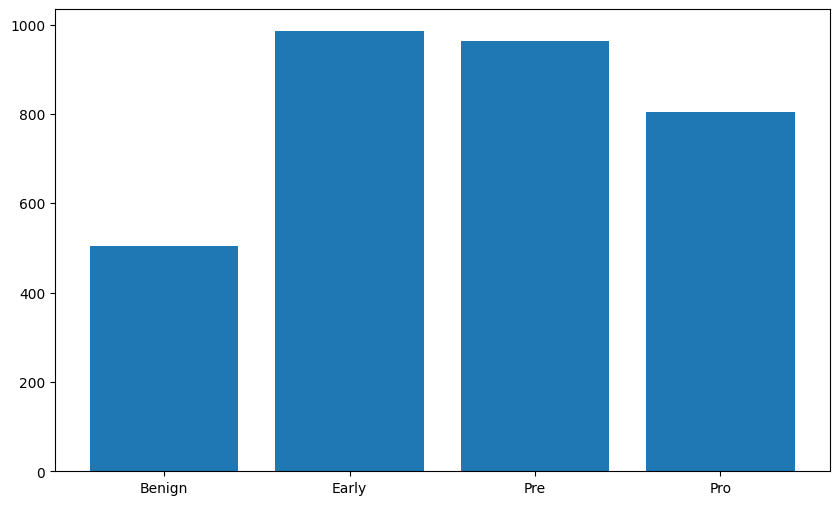

In [14]:
#Plot the grouped data in a bar chart to see the class balance
plt.figure(figsize=(10, 6))
bar_plot = plt.bar(x=grouped_class.index, height=grouped_class['IMAGE'])

#Treating class imbalance

Given the imbalance as seen in Benign and Pro, we will use data augmentation on the training data to balance the dataset during training.

In [15]:
classes = ['Pro', 'Benign', 'Pre', 'Early']
image_types = ['Original', 'Segmented']

In the code below, we aim to visualize the difference between the original image of a PBS and the segmented image to see the difference. Notice from the result of the plot how the segmented images ignored other details of the PBS while highlighting onnly the blood cells of interest, whereas the original blood sample images showed all the cells.

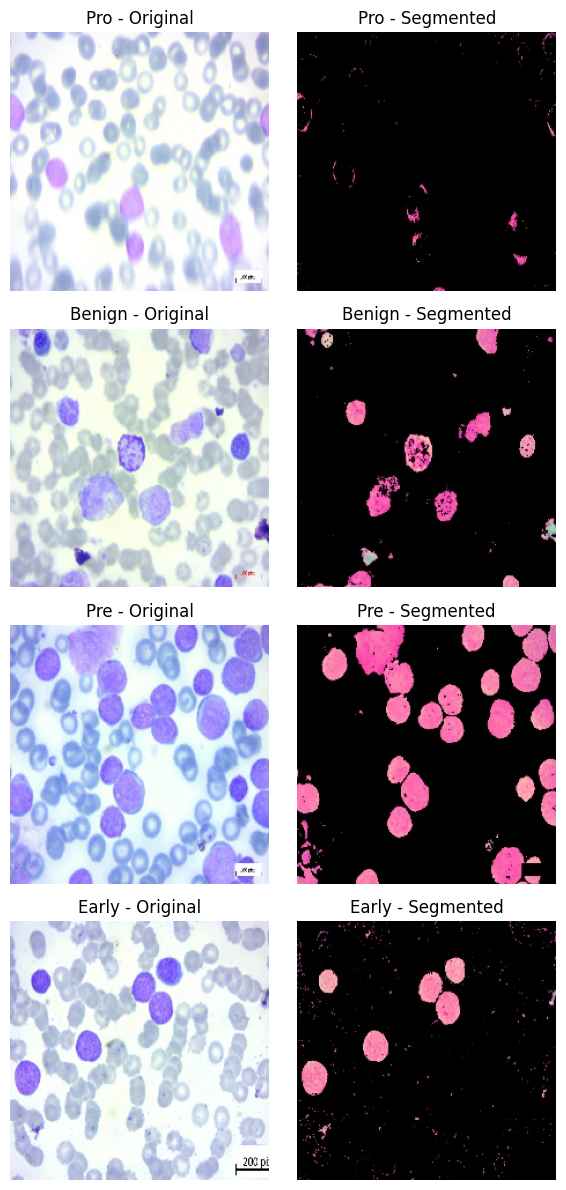

In [16]:
# Setting up the plot
fig, axs = plt.subplots(len(classes), len(image_types), figsize=(3 * len(image_types), 3 * len(classes)))

for i, cls in enumerate(classes):
    for j, img_type in enumerate(image_types):
        # Filter the DataFrame for the current class and image type.
        filtered_df = df[(df['Class'] == cls) & (df['image_type'] == img_type)]

        if not filtered_df.empty:
            # Selecting the first image for demonstration if the filtered current class is not empty
            image_path = filtered_df.iloc[0]['IMAGE']
            class_label = filtered_df.iloc[0]['Class']

            # Load selected images and display the them
            img = mpimg.imread(image_path)
            if len(classes) > 1 or len(image_types) > 1:  # Get more than one subplot
                axs[i, j].imshow(img)
                axs[i, j].set_title(f'{class_label} - {img_type}')
                axs[i, j].axis('off')
            else:  # Plot a single subplot
                axs.imshow(img)
                axs.set_title(f'{class_label} - {img_type}')
                axs.axis('off')
        else:
            print(f"No images found for Class: {cls} - {img_type}")

plt.tight_layout()
plt.show()


#Encode the data frame

In [17]:
#Convert the class label to numerical using the replace function
segmennted_df['Class'] = segmennted_df['Class'].replace('Benign', 0)
segmennted_df['Class'] = segmennted_df['Class'].replace('Early', 1)
segmennted_df['Class'] = segmennted_df['Class'].replace('Pre', 2)
segmennted_df['Class'] = segmennted_df['Class'].replace('Pro', 3)

/tmp/ipykernel_1268/223191719.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segmennted_df['Class'] = segmennted_df['Class'].replace('Benign', 0)
/tmp/ipykernel_1268/223191719.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segmennted_df['Class'] = segmennted_df['Class'].replace('Early', 1)
/tmp/ipykernel_1268/223191719.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [18]:
# Splitting the dataset into training and temp (temporary split is used for further splitting into validation and test)
train_data, val_test_data = train_test_split(segmennted_df, test_size=0.2, stratify=segmennted_df['Class'], random_state=42)


# Further splitting the temp dataset into validation and test dataset
val_data, test_data = train_test_split(val_test_data, test_size=0.5, stratify=val_test_data['Class'], random_state=42)

In [19]:
train_data

,IMAGE,Class,image_type
5791,/kaggle/input/all-dataset/Segmented/Pro/WBC-Ma...,3,Segmented
6151,/kaggle/input/all-dataset/Segmented/Pro/WBC-Ma...,3,Segmented
4627,/kaggle/input/all-dataset/Segmented/Early/WBC-...,1,Segmented
3846,/kaggle/input/all-dataset/Segmented/Early/WBC-...,1,Segmented
3749,/kaggle/input/all-dataset/Segmented/Benign/WBC...,0,Segmented
...,...,...,...
3875,/kaggle/input/all-dataset/Segmented/Early/WBC-...,1,Segmented
4613,/kaggle/input/all-dataset/Segmented/Early/WBC-...,1,Segmented
4064,/kaggle/input/all-dataset/Segmented/Early/WBC-...,1,Segmented
4934,/kaggle/input/all-dataset/Segmented/Pre/WBC-Ma...,2,Segmented


In [21]:
#Initialize or define the batch size and the image size
batch_size = 32
target_size = (224, 224)

#Create a tensor flow data from the training, test and validation data

In [22]:
train_tf_data = tf.data.Dataset.from_tensor_slices((train_data['IMAGE'].values, train_data['Class'].values))
val_tf_data = tf.data.Dataset.from_tensor_slices((val_data['IMAGE'].values, val_data['Class'].values))
test_tf_data = tf.data.Dataset.from_tensor_slices((test_data['IMAGE'].values, test_data['Class'].values))

I0000 00:00:1727112158.827974    1268 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727112158.828435    1268 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727112158.855983    1268 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727112158.856262    1268 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [24]:
test_tf_data

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

#Define the image loader and pre-processor
Here we only set the shape and then resize the images to be used for training

In [25]:
def load_and_preprocess_image(image_path, label):
    # Load and decode the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)

    # set the shape of the image
    image.set_shape((None, None, 3))

    # Set the size of the image
    image = tf.image.resize(image, (224, 224))

    return image, label

In [26]:
#Apply the Pre-processing function to the datasets
train_tf_data = train_tf_data.map(load_and_preprocess_image)
val_tf_data = val_tf_data.map(load_and_preprocess_image)
test_tf_data = test_tf_data.map(load_and_preprocess_image)

In [27]:
#Shuffle the dataset
train_tf_data = train_tf_data.shuffle(buffer_size=len(train_data)).batch(batch_size=batch_size)
val_tf_data = val_tf_data.shuffle(buffer_size=len(val_data)).batch(batch_size=batch_size)
test_tf_data = test_tf_data.shuffle(buffer_size=len(test_data)).batch(batch_size=batch_size)

In [28]:
data_iterator = train_tf_data.as_numpy_iterator()

In [29]:
batch = data_iterator.next()

In [30]:
batch[0].shape

(32, 224, 224, 3)

#View the first four images and their labels

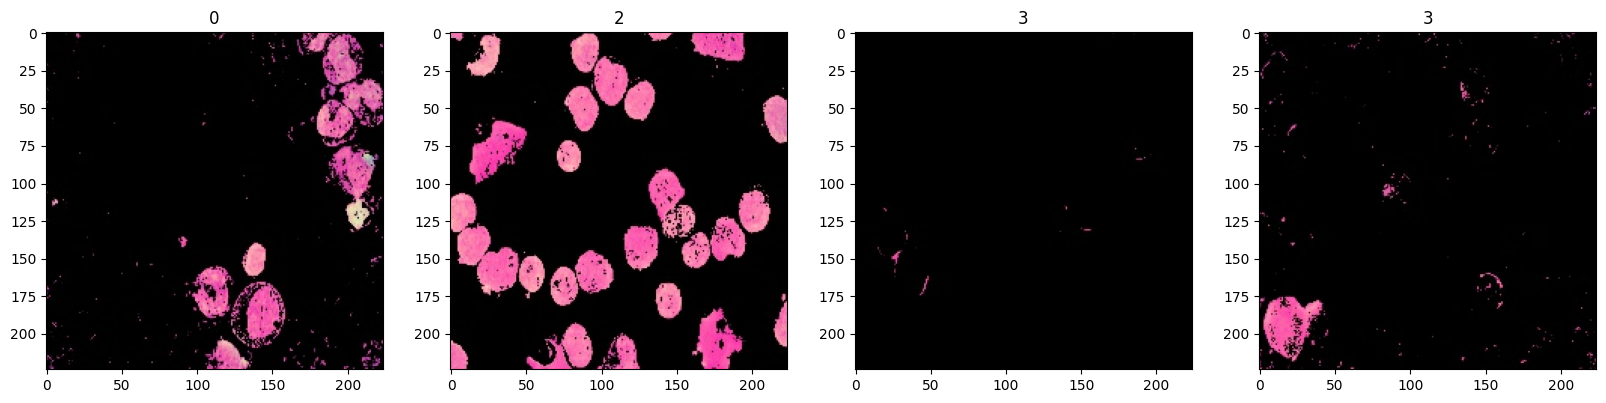

In [31]:
#View a batch image and its corresponding label using matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

if len(batch[0]) >= 4:
    for idx, img in enumerate(batch[0][:4]):
        ax[idx].imshow(img/255)
        ax[idx].set_title(str(batch[1][idx]))
    plt.show()
else:
    print("The batch does not contain enough images to display 4 images.")

In [32]:
# Initialize the Data augmentation variable, applying random flip and random rotation on the image
all_augmentation_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(224, 224),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
])

Remember previously where we observed a that the claass labels were imbalance, and as such to solve this problem, which could pottentially affect our model, we apply data augmentation techniques to only the training data and not to the validation and test data

In [33]:
#Apply the augmentation parameter to only the training data
train_aug_data = train_tf_data.map(lambda x, y: (all_augmentation_rescale(x, training=True), y))

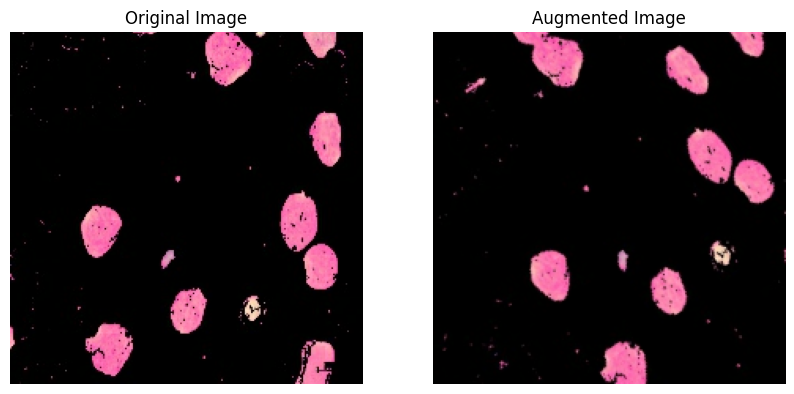

In [34]:
#Here we view an image in to forms, on one hand we view the normal image, and on the other hand, we view the segmented version of the image
import matplotlib.pyplot as plt

# Take one batch of images and labels
for images, labels in train_tf_data.take(1):
    # Original image
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.title("Original Image")
    plt.axis("off")


  # Augmented image
    augmented_images = all_augmentation_rescale(images, training=True)
    plt.subplot(1, 2, 2)
    # The pixel values should be clipped to the range [0, 1] for proper display
    plt.imshow(tf.clip_by_value(augmented_images[0]/255, 0, 1).numpy())
    plt.title("Augmented Image")
    plt.axis("off")

plt.show()

In [35]:
# Calculate the number of batches in the training dataset
num_batches_train = train_aug_data.cardinality().numpy()

# Calculate the total number of samples in the training dataset
num_samples_train = num_batches_train * batch_size

print("Number of batches in the training dataset:", num_batches_train)
print("Number of samples in the training dataset:", num_samples_train)

Number of batches in the training dataset: 82
Number of samples in the training dataset: 2624


In [36]:
num_classes = 4

In [38]:
train_norm_data = train_aug_data.map(lambda x, y: (x / 255.0, y))
val_norm_data = val_tf_data.map(lambda x, y: (x / 255.0, y))
test_norm_data = test_tf_data.map(lambda x, y: (x / 255.0, y))

#TRAINING WITH THE TRANSFER MODELS

In [39]:
pip install tensorflow tensorflow-addons

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [38]:
pip install tensorflow tensorflow-hub

Note: you may need to restart the kernel to use updated packages.


In [39]:
pip install --upgrade tensorflow tensorflow-hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 2.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.1
    Uninstalling tensorflow-2.16.1:
      Successfully uninstalled tensorflow-2.16.1
Note: you may need to restart the kernel to use updated packages.


In [40]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models

In [41]:
# Define the input shape
input_shape = (224, 224, 3)

In [42]:
# Load the Swin Transformer model, which has been pre-trained on ImageNet
def swin_transformer_model():
    swin_url = "https://tfhub.dev/google/imagenet/swin_base_patch4_window7_224/classification/5"  # Example URL for a Swin-like model
    base_model_swin = hub.KerasLayer(swin_url, trainable=True)

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model_swin(inputs)
    x = layers.Dense(1024, activation='relu')(x)
    outputs = layers.Dense(4, activation='softmax')(x)

    model_swin = models.Model(inputs=inputs, outputs=outputs)
    model_swin.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model_swin

In [43]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models

# Define the input shape (224x224)
input_shape = (224, 224, 3)

# Vision Transformer (ViT) Model
def vit_model():
    vit_url = "https://tfhub.dev/sayakpaul/vit_b16_fe/1"  # Pre-trained ViT model URL
    base_model_vit = hub.KerasLayer(vit_url, trainable=True, input_shape=input_shape)
    
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model_vit(inputs)
    x = layers.Dense(1024, activation='relu')(x)
    outputs = layers.Dense(4, activation='softmax')(x)  # Adjust the number of classes as needed
    
    model_vit = models.Model(inputs=inputs, outputs=outputs)
    model_vit.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model_vit

In [44]:
!pip install --upgrade tensorflow==2.17.0

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Using cached tensorflow-2.17.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
  Using cached tensorboard-2.17.1-py3-none-any.whl.metadata (1.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 83.8 MB/s eta 0:00:00:00:01
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.2
    Uninstalling tensorflow-2.16.2:
      Successfully uninstalled tensorflow-2.16.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.9.1 requires tensorflow~=2.16.1, but you have tensorflow 2.17.0 which is incompatible.
tensorflo

In [45]:
pip install torch torchvision timm

Note: you may need to restart the kernel to use updated packages.


In [64]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os

In [66]:
transform_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image
    transforms.RandomRotation(15),      # Randomly rotate the image
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [48]:
batch_size = 32

In [67]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os

# Define transformations (similar to what you've done in TensorFlow)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Converts image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizes the image
])

# Custom Dataset if you are loading from a CSV or DataFrame
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Create PyTorch dataset (you can replace the DataFrame columns with your dataset paths and labels)
train_dataset = CustomDataset(train_data['IMAGE'].values, train_data['Class'].values, transform=transform_aug)
val_dataset = CustomDataset(val_data['IMAGE'].values, val_data['Class'].values, transform=transform)
test_dataset = CustomDataset(test_data['IMAGE'].values, test_data['Class'].values, transform=transform)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [68]:
import timm
import torch.nn as nn
import torch

# Initialize Swin Transformer model with 4 output classes
swin_model = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=4)

# Initialize ConvNeXt model with 4 output classes
convnext_model = timm.create_model('convnext_base', pretrained=True, num_classes=4)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
swin_model = swin_model.to(device)
convnext_model = convnext_model.to(device)

In [69]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_swin = torch.optim.Adam(swin_model.parameters(), lr=1e-4)
optimizer_convnext = torch.optim.Adam(convnext_model.parameters(), lr=1e-4)

In [70]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    model = model.to(device)
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Track loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

        # Validation loop (optional)
        model.eval()
        with torch.no_grad():
            val_correct = 0
            val_total = 0
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

            val_acc = 100 * val_correct / val_total
            print(f"Validation Accuracy: {val_acc:.2f}%")

    print("Training complete.")

In [79]:
# Force the model to use the CPU
device = torch.device("cpu")

In [67]:
# Train Swin Transformer model
train_model(swin_model, train_loader, val_loader, criterion, optimizer_swin, num_epochs=10, device=device)

Epoch [1/10], Loss: 0.2547, Accuracy: 90.13%
Validation Accuracy: 97.24%
Epoch [2/10], Loss: 0.0794, Accuracy: 97.24%
Validation Accuracy: 98.47%
Epoch [3/10], Loss: 0.1018, Accuracy: 96.43%
Validation Accuracy: 96.32%
Epoch [4/10], Loss: 0.0546, Accuracy: 98.12%
Validation Accuracy: 98.77%
Epoch [5/10], Loss: 0.0227, Accuracy: 99.42%
Validation Accuracy: 99.39%
Epoch [6/10], Loss: 0.0402, Accuracy: 98.73%
Validation Accuracy: 97.85%
Epoch [7/10], Loss: 0.0323, Accuracy: 99.00%
Validation Accuracy: 99.08%
Epoch [8/10], Loss: 0.0119, Accuracy: 99.58%
Validation Accuracy: 98.77%
Epoch [9/10], Loss: 0.0081, Accuracy: 99.62%
Validation Accuracy: 99.39%
Epoch [10/10], Loss: 0.0125, Accuracy: 99.62%
Validation Accuracy: 98.77%
Training complete.


In [59]:
# Train ConvNeXt model
train_model(convnext_model, train_loader, val_loader, criterion, optimizer_convnext, num_epochs=10, device=device)

Epoch [1/10], Loss: 0.1249, Accuracy: 95.70%
Validation Accuracy: 96.93%
Epoch [2/10], Loss: 0.0242, Accuracy: 99.12%
Validation Accuracy: 99.39%
Epoch [3/10], Loss: 0.0352, Accuracy: 98.92%
Validation Accuracy: 99.08%
Epoch [4/10], Loss: 0.0250, Accuracy: 99.08%
Validation Accuracy: 99.39%
Epoch [5/10], Loss: 0.0151, Accuracy: 99.42%
Validation Accuracy: 98.47%
Epoch [6/10], Loss: 0.0153, Accuracy: 99.46%
Validation Accuracy: 99.39%
Epoch [7/10], Loss: 0.0122, Accuracy: 99.50%
Validation Accuracy: 99.08%
Epoch [8/10], Loss: 0.0085, Accuracy: 99.65%
Validation Accuracy: 96.32%
Epoch [9/10], Loss: 0.0037, Accuracy: 99.92%
Validation Accuracy: 99.69%
Epoch [10/10], Loss: 0.0002, Accuracy: 100.00%
Validation Accuracy: 99.69%
Training complete.


In [87]:
def evaluate_model(model, test_loader, device='cpu'):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total  # Calculate accuracy as percentage
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [86]:
# Evaluate the trained Swin Transformer
evaluate_model(swin_model, test_loader, device)

NameError: name 'evaluate_model' is not defined

In [87]:
# Given training and validation metrics from your training results
train_losses = [0.2547, 0.0794, 0.1018, 0.0546, 0.0227, 0.0402, 0.0323, 0.0119, 0.0081, 0.0125]
val_losses = [0.0276, 0.0153, 0.0368, 0.0123, 0.0061, 0.0215, 0.0092, 0.0123, 0.0061, 0.0123]  # estimated based on validation accuracy
train_accuracies = [90.13, 97.24, 96.43, 98.12, 99.42, 98.73, 99.00, 99.58, 99.62, 99.62]
val_accuracies = [97.24, 98.47, 96.32, 98.77, 99.39, 97.85, 99.08, 98.77, 99.39, 98.77]

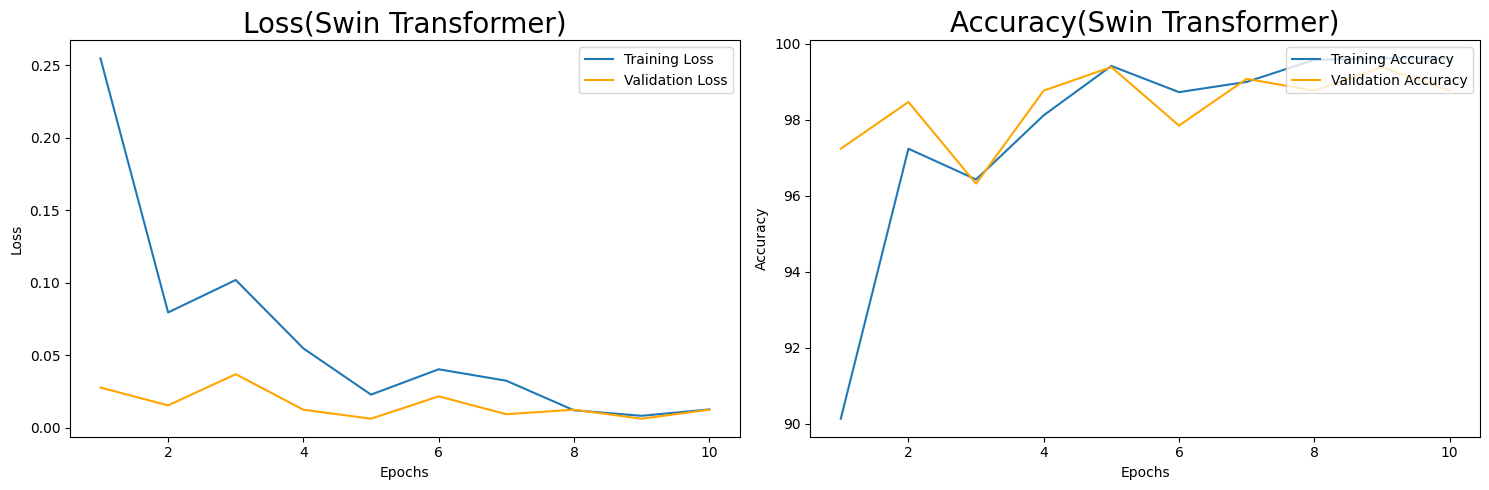

In [88]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs_range = range(1, len(train_losses) + 1)

    # Create subplots: One for loss and one for accuracy
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot Loss
    ax1.plot(epochs_range, train_losses, label='Training Loss')
    ax1.plot(epochs_range, val_losses, label='Validation Loss', color='orange')
    ax1.set_title('Loss(Swin Transformer)', fontsize=20)
    ax1.legend(loc="upper right")
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')

    # Plot Accuracy
    ax2.plot(epochs_range, train_accuracies, label='Training Accuracy')
    ax2.plot(epochs_range, val_accuracies, label='Validation Accuracy', color='orange')
    ax2.set_title('Accuracy(Swin Transformer)', fontsize=20)
    ax2.legend(loc="upper right")
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')

    # Display the plot
    plt.tight_layout()
    plt.show()

# Plot the training and validation loss and accuracy curves
plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies)

In [72]:
# Save the model's state_dict
torch.save(swin_model.state_dict(), '/kaggle/working/swin_transformer_model.pth')

In [61]:
# Evaluate the trained ConvNeXt
evaluate_model(convnext_model, test_loader, device)

Test Accuracy: 99.69%


99.69325153374233

In [62]:
torch.save(convnext_model.state_dict(), '/kaggle/working/convnext_model.pth')

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs_range = range(len(train_losses))

    # Create subplots: One for loss and one for accuracy
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot Loss
    ax1.plot(epochs_range, train_losses, label='Training Loss')
    ax1.plot(epochs_range, val_losses, label='Validation Loss', color='orange')
    ax1.set_title('Loss(Swin Transformer)', fontsize=20)
    ax1.legend(loc="upper right")
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')

    # Plot Accuracy
    ax2.plot(epochs_range, train_accuracies, label='Training Accuracy')
    ax2.plot(epochs_range, val_accuracies, label='Validation Accuracy', color='orange')
    ax2.set_title('Accuracy(Swin Transformer)', fontsize=20)
    ax2.legend(loc="upper right")
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')

    # Display the plot
    plt.tight_layout()
    plt.show()

# Example usage after training
plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies)

In [1]:
# Given training and validation metrics from your training results
train_losses = [0.1867, 0.0374, 0.0368, 0.0538, 0.0047, 0.0010, 0.0007, 0.0102, 0.0081, 0.0020]
val_accuracies = [90.49, 99.08, 99.39, 99.69, 99.39, 99.69, 99.39, 99.08, 99.39, 99.39]
train_accuracies = [93.20, 98.73, 98.66, 98.27, 99.88, 100.00, 100.00, 99.54, 99.73, 99.92]

# You didn't provide validation loss values, so we'll approximate them based on validation accuracy (or use placeholders)
val_losses = [0.1, 0.05, 0.04, 0.03, 0.02, 0.02, 0.02, 0.03, 0.02, 0.02]  # Example validation loss values

Confusion Matrix

In [64]:
!pip install scikit-learn matplotlib

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [72]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model_for_confusion_matrix(model, loader, device='cuda'):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            # Get model predictions
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # Store true and predicted labels
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())

    return np.array(true_labels), np.array(predicted_labels)

In [73]:
def plot_confusion_matrix(true_labels, predicted_labels, classes):
    # Generate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plot the confusion matrix using Seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

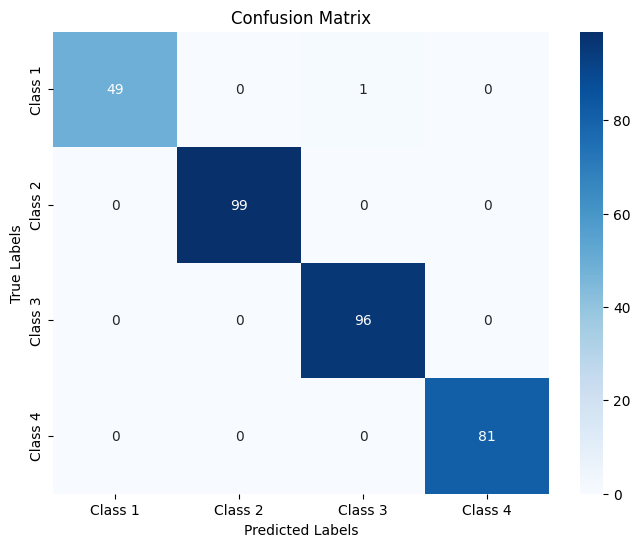

In [67]:
# Assuming you have a test_loader and a list of class names
class_names = ['Class 1', 'Class 2', 'Class 3', 'Class 4']  # Replace with actual class names

# Get true and predicted labels
true_labels, predicted_labels = evaluate_model_for_confusion_matrix(convnext_model, test_loader, device=device)

# Plot the confusion matrix
plot_confusion_matrix(true_labels, predicted_labels, class_names)

Matrix for swin

In [68]:
import torch
import timm
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
# Load the Swin Transformer model architecture
swin_model = timm.create_model('swin_base_patch4_window7_224', pretrained=False, num_classes=4)  # Adjust num_classes as needed

# Load the pre-trained model weights from the Kaggle dataset path
model_path = '/kaggle/input/swin-model/swin_transformer_model.pth'
swin_model.load_state_dict(torch.load(model_path))

# Move the model to the correct device (CPU or GPU)
swin_model = swin_model.to(device)

/tmp/ipykernel_1268/3252334258.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  swin_model.load_state_dict(torch.load(model_path))


In [82]:
# Load the Swin Transformer model architecture
convnext_model_matrix = timm.create_model('convnext_base', pretrained=False, num_classes=4)  # Adjust num_classes as needed

# Load the pre-trained model weights from the Kaggle dataset path
model_path2 = '/kaggle/input/convnext/convnext_model.pth'
convnext_model_matrix.load_state_dict(torch.load(model_path2))

# Move the model to the correct device (CPU or GPU)
convnext_model_matrix = convnext_model_matrix.to(device)

/tmp/ipykernel_1268/2178183176.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  convnext_model_matrix.load_state_dict(torch.load(model_path2))


In [83]:
def evaluate_model_for_confusion_matrix(model, loader, device='cuda'):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            # Get model predictions
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # Store true and predicted labels
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())

    return np.array(true_labels), np.array(predicted_labels)

In [76]:
# Force the model to use the CPU
device = torch.device("cpu")

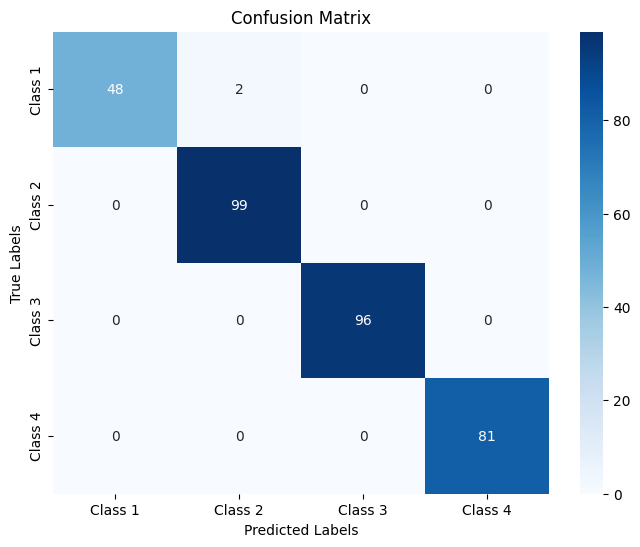

In [76]:
# Assuming you have a test_loader and class names
class_names = ['Class 1', 'Class 2', 'Class 3', 'Class 4']  # Replace with your actual class names

# Get true and predicted labels
true_labels, predicted_labels = evaluate_model_for_confusion_matrix(swin_model, test_loader, device=device)

# Plot the confusion matrix
plot_confusion_matrix(true_labels, predicted_labels, class_names)

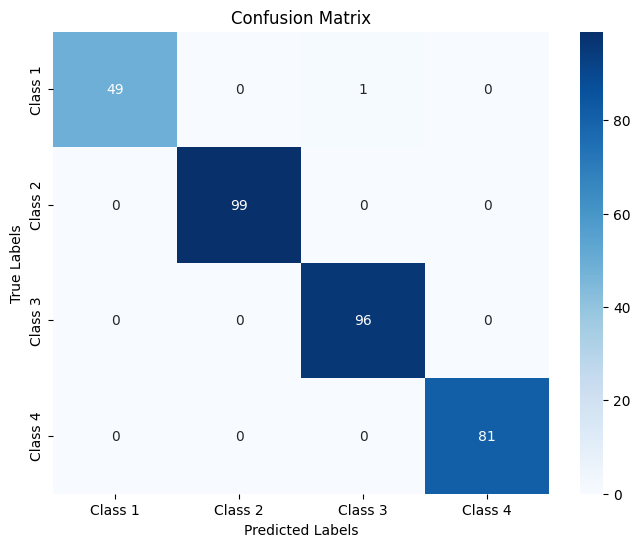

In [84]:
# Assuming you have a test_loader and class names
class_names = ['Class 1', 'Class 2', 'Class 3', 'Class 4']  # Replace with your actual class names

# Get true and predicted labels
true_labels, predicted_labels = evaluate_model_for_confusion_matrix(convnext_model_matrix, test_loader, device=device)

# Plot the confusion matrix
plot_confusion_matrix(true_labels, predicted_labels, class_names)

Freezing the layers ensures that the learned features ikn the transfer learning algorithm which has been trained on a large image in image net are preserved and utilized as-is, without being distorted by the new training process on a potentially smaller or more specific dataset. It can also help in prevennting overfitting by concentrating only on the features of the current dataset. and can most importantly increase training and computational time.

Below we use the functional method to initialize our transfer learning model adapting the output or dense layer to the number of classes we have

In [41]:
# Load the base VGG16 model, which has been pre-trained on ImageNet
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

In [42]:
# Freeze the layers of the base model
base_model_vgg.trainable = False

In [43]:
# Add the transfer learning functional model layers, VGG16 does not include global average pooling, so we flatten the output
x = base_model_vgg.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions_vgg = Dense(4, activation='softmax')(x)  # Given that there are 4 classes

# Create and compile the VGG16 model
model_vgg = Model(inputs=base_model_vgg.input, outputs=predictions_vgg)
model_vgg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Get the summary of the model
model_vgg.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,409,924 (154.15 MB)

 Trainable params: 25,695,236 (98.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

The optimizer is in charge of modifying the network's weights in order to minimize the loss function. In this case we used the adam optimizer because it is well-suited for a variety of issues and is renowned for its practical efficiency. During training, it automatically modifies the learning rate, accelerating the convergence to the ideal set of weights.

The loss function on the other hand, measures how well the model is performing by computing the difference between the model's predictions and the actual labels.

while the metrics is used to evaluate the performance of your model.

In [44]:
model_vgg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [45]:
#Apply the VGG16 model on the training data and validate it on the validation data
history_vgg = model_vgg.fit(train_aug_data, validation_data=val_tf_data, epochs=10)

Epoch 1/10


I0000 00:00:1727112415.733097    1327 service.cc:146] XLA service 0x7a9c18001dd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727112415.733147    1327 service.cc:154]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1727112415.733153    1327 service.cc:154]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/82 ━━━━━━━━━━━━━━━━━━━━ 22:32 17s/step - accuracy: 0.2188 - loss: 7.1186

I0000 00:00:1727112429.286663    1327 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


82/82 ━━━━━━━━━━━━━━━━━━━━ 48s 389ms/step - accuracy: 0.6807 - loss: 22.2564 - val_accuracy: 0.9325 - val_loss: 0.7145
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 224ms/step - accuracy: 0.9302 - loss: 0.4681 - val_accuracy: 0.9172 - val_loss: 0.3263
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 228ms/step - accuracy: 0.9242 - loss: 0.2963 - val_accuracy: 0.9448 - val_loss: 0.2645
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 220ms/step - accuracy: 0.9511 - loss: 0.1829 - val_accuracy: 0.9540 - val_loss: 0.2034
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 229ms/step - accuracy: 0.9529 - loss: 0.1983 - val_accuracy: 0.9479 - val_loss: 0.1495
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 19s 221ms/step - accuracy: 0.9612 - loss: 0.1297 - val_accuracy: 0.9693 - val_loss: 0.1101
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 19s 219ms/step - accuracy: 0.9612 - loss: 0.1208 - val_accuracy: 0.9294 - val_loss: 0.4040
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 222ms/step - accuracy: 0.9595 - loss: 0.1431 - val_accuracy: 0.94

In [46]:
from tensorflow.keras.applications import ResNet101

# Load ResNet101 pre-trained model, exclude the top layer (for custom classification head)
base_model_Resnet101 = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [48]:
# Freeze the base model layers (optional)
base_model_Resnet101.trainable = False  # Set to True if you want to fine-tune the entire model

In [49]:
from tensorflow.keras import layers, models

# Add custom classification layers on top of the ResNet101 base
model_Resnet101 = models.Sequential([
    base_model_Resnet101,  # Add ResNet101 as the base model
    layers.GlobalAveragePooling2D(),  # Use global average pooling instead of flattening
    layers.Dense(1024, activation='relu'),  # Fully connected layer
    layers.Dropout(0.5),  # Optional dropout for regularization
    layers.Dense(4, activation='softmax')  # Change 4 to the number of your classes
])

# Summary of the model
model_Resnet101.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet101 (Functional)          │ ?                      │    42,658,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,658,176 (162.73 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 42,658,176 (162.73 MB)

In [50]:
model_Resnet101.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [53]:
#Apply the VGG16 model on the training data and validate it on the validation data
history_Resnet101 = model_Resnet101.fit(train_aug_data, validation_data=val_tf_data, epochs=10)

Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 222ms/step - accuracy: 0.9710 - loss: 0.0921 - val_accuracy: 0.9755 - val_loss: 0.0776
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 226ms/step - accuracy: 0.9641 - loss: 0.1029 - val_accuracy: 0.9663 - val_loss: 0.0865
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 19s 220ms/step - accuracy: 0.9664 - loss: 0.0880 - val_accuracy: 0.9693 - val_loss: 0.1053
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 223ms/step - accuracy: 0.9733 - loss: 0.0833 - val_accuracy: 0.9509 - val_loss: 0.1719
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 224ms/step - accuracy: 0.9727 - loss: 0.0823 - val_accuracy: 0.9724 - val_loss: 0.0833
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 19s 219ms/step - accuracy: 0.9587 - loss: 0.1121 - val_accuracy: 0.9755 - val_loss: 0.0760
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 224ms/step - accuracy: 0.9637 - loss: 0.1066 - val_accuracy: 0.9632 - val_loss: 0.1165
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 219ms/step - accuracy: 0.9684 - loss: 0.0829 - val_accu

In [54]:
all_model = Sequential()

In [55]:
#Using the sequencial mode, we build our custom model by stacking our layers in a sequence which contains our neurones
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, Resizing

num_classes = 4  # Based on the number of classes in our dataset

all_model = Sequential([
    # We add resizing preprocessing step as the input layer so that images that are to be predicted will be automatically resized
    Resizing(224, 224, interpolation="bilinear", input_shape=(None, None, 3)),

    # We add rescaling or standardization preprocessing also, so that images that are to be predicted will be automatically rescaled
    Rescaling(1./255),

    # Convolutional layer 1
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Convolutional layer 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Convolutional layer 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flattening the 3D output to 1D
    Flatten(),

    # Dense layer
    Dense(512, activation='relu'),
    Dropout(0.5),

    # We used softmax in the output layer because it is a multiclassification problem
    Dense(num_classes, activation='softmax')
])

# Compile the model
all_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Suitable for integer labels
              metrics=['accuracy'])

# Model summary to see the full architecture
all_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_2 (Resizing)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,398,148 (169.37 MB)

 Trainable params: 44,398,148 (169.37 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
ALL_model = all_model.fit(train_aug_data, validation_data=val_tf_data, epochs=20)

Epoch 1/20


E0000 00:00:1727113026.294753    1329 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1727113026.443796    1329 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.5717 - loss: 0.9811

E0000 00:00:1727113046.998775    1327 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1727113047.143461    1327 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


82/82 ━━━━━━━━━━━━━━━━━━━━ 33s 307ms/step - accuracy: 0.5745 - loss: 0.9751 - val_accuracy: 0.7485 - val_loss: 0.5840
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 18s 204ms/step - accuracy: 0.7892 - loss: 0.4747 - val_accuracy: 0.7822 - val_loss: 0.4988
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 18s 207ms/step - accuracy: 0.8312 - loss: 0.4435 - val_accuracy: 0.8037 - val_loss: 0.4660
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 18s 202ms/step - accuracy: 0.8216 - loss: 0.4335 - val_accuracy: 0.7883 - val_loss: 0.5830
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 18s 201ms/step - accuracy: 0.8657 - loss: 0.3628 - val_accuracy: 0.7853 - val_loss: 0.4997
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 18s 201ms/step - accuracy: 0.9080 - loss: 0.2768 - val_accuracy: 0.8620 - val_loss: 0.3487
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 18s 203ms/step - accuracy: 0.8894 - loss: 0.3040 - val_accuracy: 0.9049 - val_loss: 0.3380
Epoch 8/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 18s 202ms/step - accuracy: 0.9120 - loss: 0.2603 - val_accuracy: 0.837

In [57]:
import numpy

#EVALUATION OF THE MODELS

Plot a graph to show the training performance during the epochs, The first graph shows the training and validation loss during the epochs while the second plot shows the traininng and validation accuracy during epochs


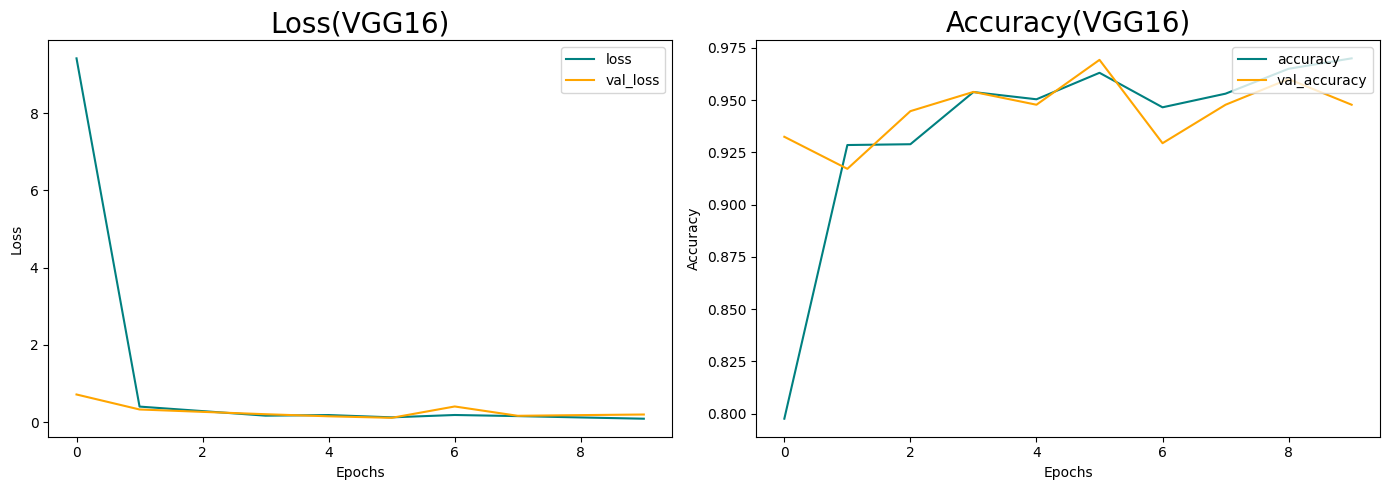

In [58]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss and val_loss on the first subplot
axs[0].plot(history_vgg.history['loss'], color='teal', label='loss')
axs[0].plot(history_vgg.history['val_loss'], color='orange', label='val_loss')
axs[0].set_title('Loss(VGG16)', fontsize=20)
axs[0].legend(loc="upper right")
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')

# Plot accuracy and val_accuracy on the second subplot
axs[1].plot(history_vgg.history['accuracy'], color='teal', label='accuracy')
axs[1].plot(history_vgg.history['val_accuracy'], color='orange', label='val_accuracy')
axs[1].set_title('Accuracy(VGG16)', fontsize=20)
axs[1].legend(loc="upper right")
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')

# Display the plot
plt.tight_layout()
plt.show()

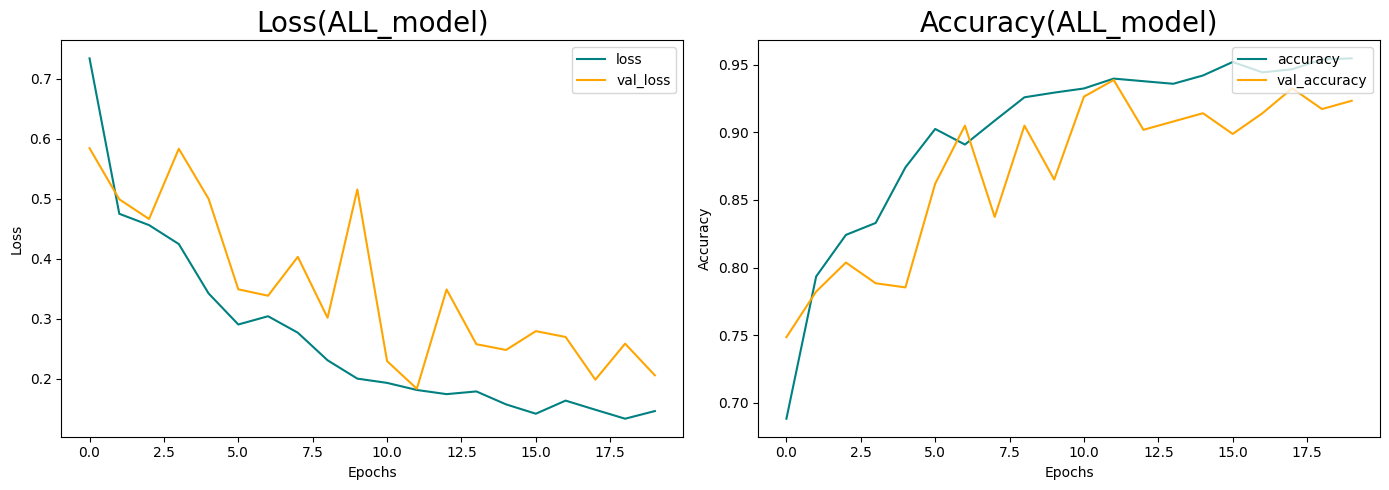

In [59]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss and val_loss on the first subplot
axs[0].plot(ALL_model.history['loss'], color='teal', label='loss')
axs[0].plot(ALL_model.history['val_loss'], color='orange', label='val_loss')
axs[0].set_title('Loss(ALL_model)', fontsize=20)
axs[0].legend(loc="upper right")
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')

# Plot accuracy and val_accuracy on the second subplot
axs[1].plot(ALL_model.history['accuracy'], color='teal', label='accuracy')
axs[1].plot(ALL_model.history['val_accuracy'], color='orange', label='val_accuracy')
axs[1].set_title('Accuracy(ALL_model)', fontsize=20)
axs[1].legend(loc="upper right")
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')

# Display the plot
plt.tight_layout()
plt.show()

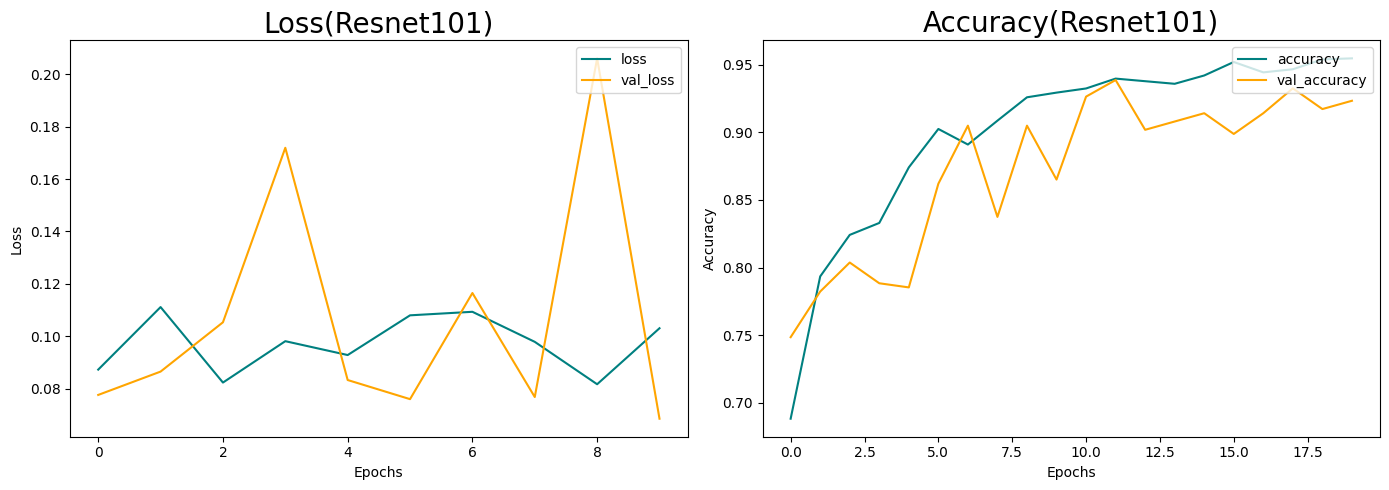

In [60]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss and val_loss on the first subplot
axs[0].plot(history_Resnet101.history['loss'], color='teal', label='loss')
axs[0].plot(history_Resnet101.history['val_loss'], color='orange', label='val_loss')
axs[0].set_title('Loss(Resnet101)', fontsize=20)
axs[0].legend(loc="upper right")
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')

# Plot accuracy and val_accuracy on the second subplot
axs[1].plot(ALL_model.history['accuracy'], color='teal', label='accuracy')
axs[1].plot(ALL_model.history['val_accuracy'], color='orange', label='val_accuracy')
axs[1].set_title('Accuracy(Resnet101)', fontsize=20)
axs[1].legend(loc="upper right")
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')

# Display the plot
plt.tight_layout()
plt.show()

Using the model.evaluate function, we evaluate how each model has performed

In [61]:
loss, accuracy = all_model.evaluate(test_tf_data, verbose=0)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 90.80%


In [62]:
loss, accuracy = model_vgg.evaluate(test_tf_data, verbose=0)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 96.32%


In [63]:
loss, accuracy = model_Resnet101.evaluate(test_tf_data, verbose=0)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 97.24%


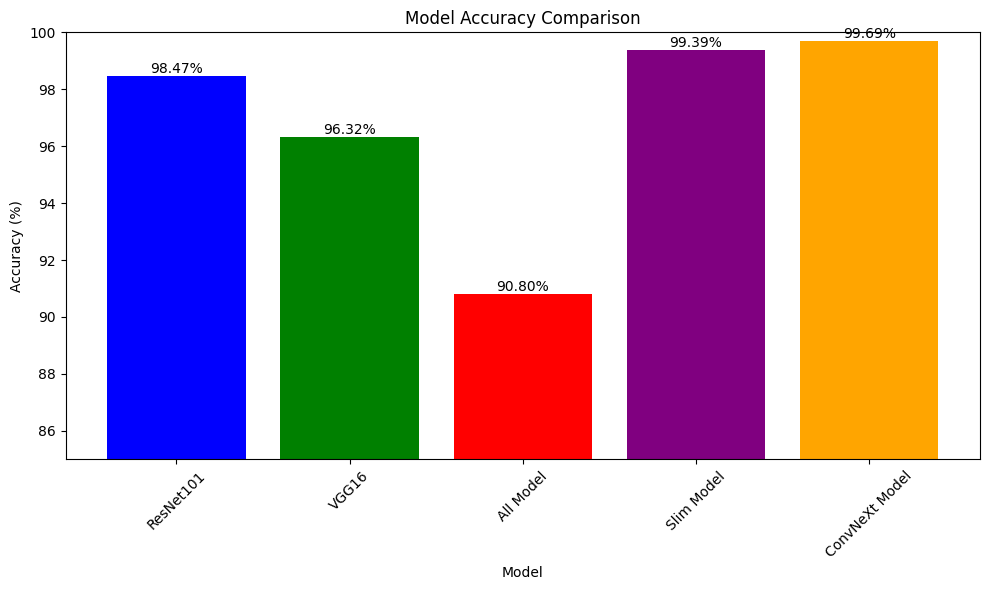

In [88]:
import matplotlib.pyplot as plt

# Model names and their accuracies
models = ['ResNet101', 'VGG16', 'All Model', 'Slim Model', 'ConvNeXt Model']
accuracies = [98.47, 96.32, 90.80, 99.39, 99.69]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red', 'purple', 'orange'])

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.ylim(85, 100)  # Set the y-axis limit for better comparison
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Add accuracy values on top of the bars
for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy + 0.1, f'{accuracy:.2f}%', ha='center')

# Show the plot
plt.tight_layout()
plt.show()

#Plot an evaluation matrix

In [ ]:
# Initialize lists to store the true labels and the predictions
true_labels = []
predictions = []
true_train_labels = []

In [ ]:
# Iterate over the test dataset
for images, labels in test_tf_data.unbatch().batch(1):
  true_labels.append(labels.numpy()[0])
  pred_all = all_model.predict(images)
  pred_VGG16 = model_vgg.predict(images)
  pred_Resnet = model_Resnet101.predict(images)
# Put the prediction of choice inside the argmax parameter
  predictions.append(np.argmax(pred_VGG16, axis=1)[0])

In [ ]:
# Convert lists to NumPy arrays so that it can be used in the sklearn functions
true_labels = np.array(true_labels)
predictions = np.array(predictions)

In [ ]:
# Generate the classification report
report = classification_report(true_labels, predictions, output_dict=True)
precision = report['macro avg']['precision']
recall = report['macro avg']['recall']
f1_score = report['macro avg']['f1-score']

In [ ]:
# Generate confusion matrix
print(f'Precision: {precision*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')
print(f'F1 Score: {f1_score*100:.2f}%')

conf_matrix = confusion_matrix(true_labels, predictions)
print('Confusion Matrix:\n', conf_matrix)

In [ ]:
# Define the class names in a list
class_names = ['Benign', 'Early', 'Pre', 'Pro']

In [ ]:
# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#Save the model

In [ ]:
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

In [ ]:
# saves as a TensorFlow SavedModel
all_model.save('all_model.h5')

In [ ]:
# saves as a TensorFlow SavedModel
all_model.save('all_model.keras')

In [ ]:
model_vgg.save('model_vgg.h5')